In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg

datafilename = "data_processed-outliers-replaced.csv"
d = pd.read_csv(datafilename)
print("Loading", len(d), "lines of data (outliers replaced).")

resultsfilename = "data_stats-outliers-replaced.csv"
st = pd.read_csv(resultsfilename)
print("Loading", len(st), "lines of stats.")

Loading 15768 lines of data (outliers replaced).
Loading 876 lines of stats.


In [2]:
# comparison by design training

types = ["lexical", "recognition"]
fonts = ["arial", "sansforgetica"]
skills = ["Designer", "Non-designer"]
metrics = ["RT", "RT_word", "RT_nonword", "AUC", "AUC_word", "AUC_nonword"]
RTs = metrics[:3]
AUCs = metrics[3:]

cols = pd.MultiIndex.from_product([skills, metrics, ["mean", "SEM"]], names=["skill", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for skill in skills:
        if skill == "Designer":
            r = st[st["isDesigner"] & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        else:
            r = st[(st["isDesigner"] == False) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (skill, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (skill, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-design-expertise.csv")

skill                         Designer                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial          2399.33  111.245  1631.84   44.622    3166.82   
                sansforgetica  2877.33  322.626  1904.75  78.7378     3849.9   
    recognition arial          2221.56   85.679  2117.91  98.4176    2325.21   
                sansforgetica  2356.18  93.4928  2245.21   101.97    2467.15   
2   lexical     arial          2440.13  138.666     1748  77.2724    3132.26   
                sansforgetica  2887.05  190.959  1974.48  89.7685    3799.63   
    recognition arial          2288.05  80.2704  2152.39  77.8859    2423.71   
                sansforgetica  2962.54  565.387  2166.59  89.5364    3758.49   

skill                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          195.576  0.971792    0.006492       NaN   
                sansforgetica  583.977  0.979434  0.00528001       NaN   
    recognition arial          81.0919  0.896521   0.0146142  0.880307   
                sansforgetica  95.6104  0.890478   0.0161991  0.870283   
2   lexical     arial          227.007  0.941111   0.0135209       NaN   
                sansforgetica  312.115  0.928571    0.015384       NaN   
    recognition arial          98.4597  0.842262   0.0170546  0.850198   
                sansforgetica  1122.97  0.847718   0.0171733  0.865575   

skill                                       ...     Non-designer           \
metric                                      ...          RT_word            
stat                                 SEM    ...             mean      SEM   
sid type        font                        ...                             
1   lexical     arial                NaN    ...          2068.25  104.259   
                sansforgetica        NaN    ...           2278.4  123.275   
    recognition arial           0.018187    ...          2596.11  133.077   
                sansforgetica  0.0213533    ...          2510.85  103.181   
2   lexical     arial                NaN    ...          1879.53  82.9322   
                sansforgetica        NaN    ...          2052.38  69.7501   
    recognition arial          0.0210145    ...          2358.74  94.2052   
                sansforgetica   0.019009    ...          2365.39  70.3291   

skill                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial            3265.53  188.029  0.973182  0.00716037   
                sansforgetica    3894.77  254.877     0.975  0.00788058   
    recognition arial            2742.45   160.85  0.901989   0.0154599   
                sansforgetica    2858.99  114.207  0.916016   0.0124777   
2   lexical     arial            3385.24  403.034  0.967881  0.00831703   
                sansforgetica    3870.43  328.591  0.978475  0.00556332   
    recognition arial            2621.71  101.227  0.893935   0.0143146   
                sansforgetica    2719.43  97.9346  0.869306   0.0152657   

skill                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexical     aria

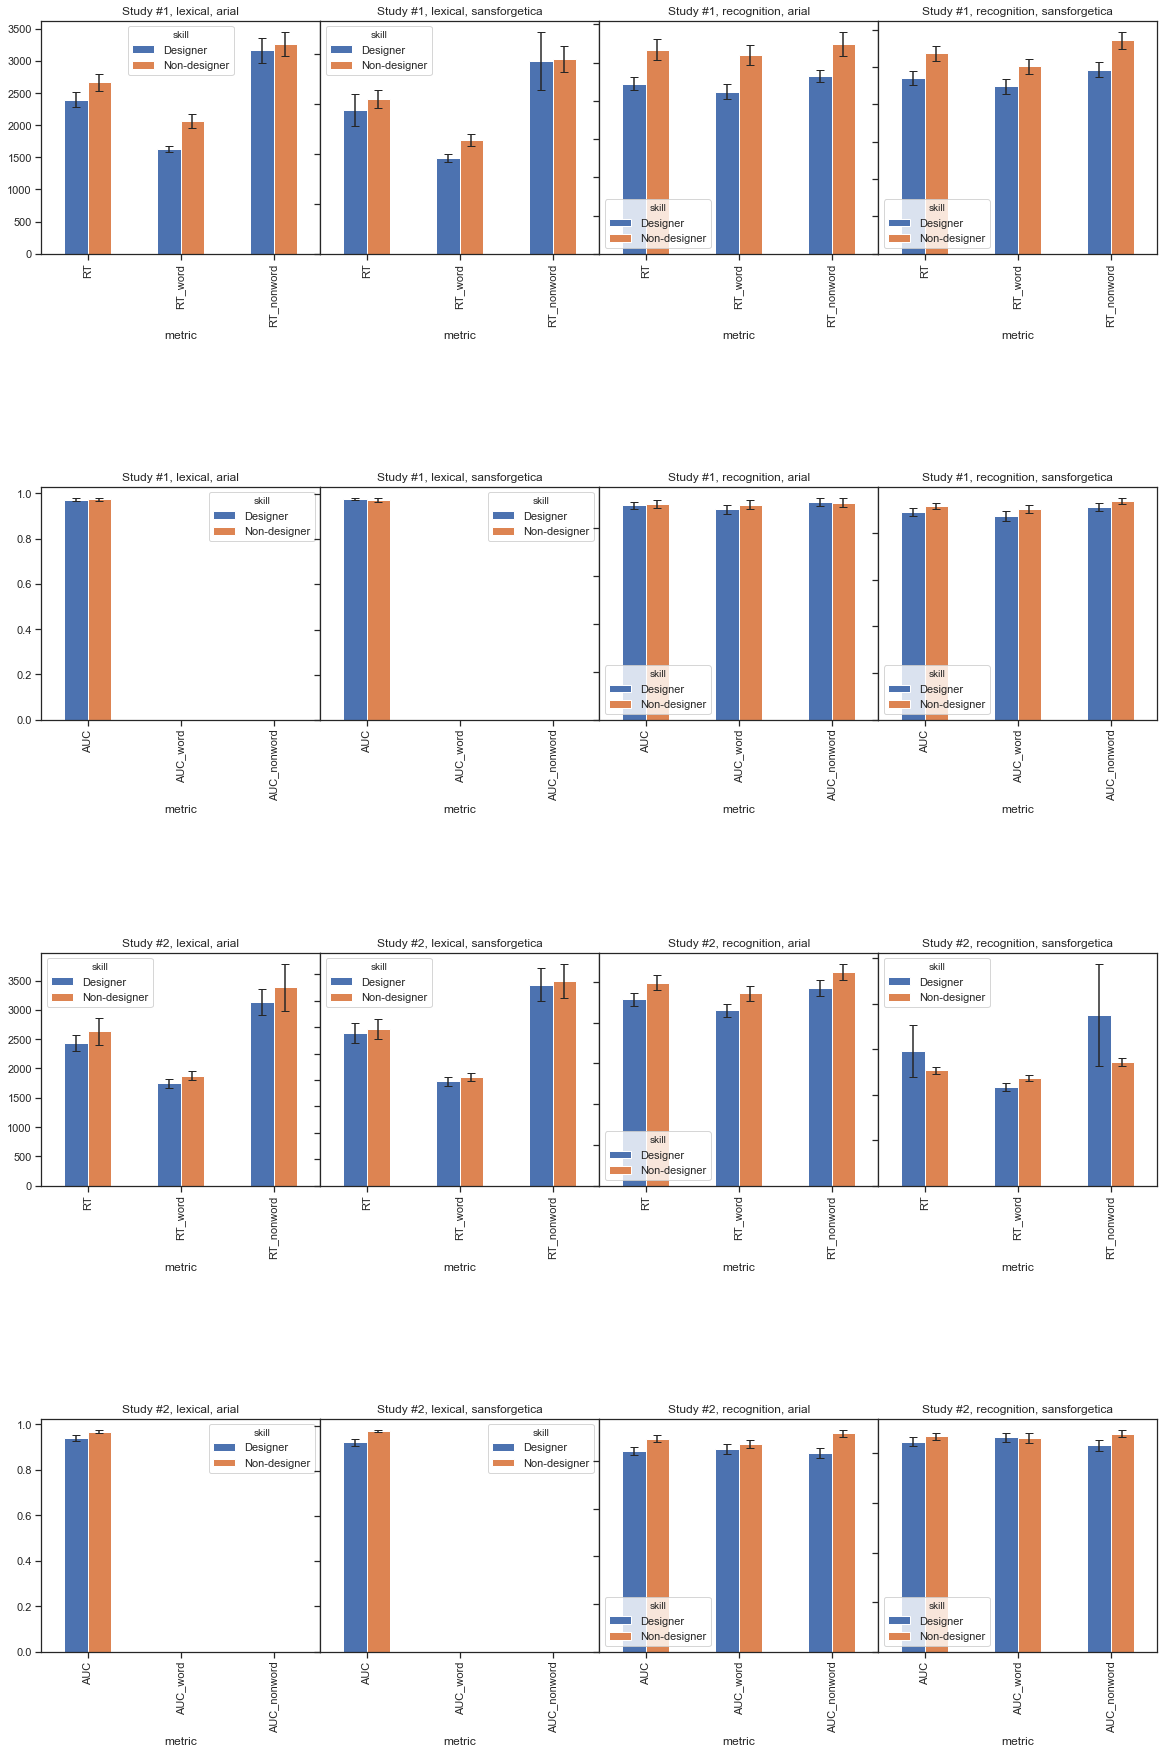

In [3]:
# comparison by design training - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-design-expertise.pdf")

In [4]:
# comparison by order

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order.csv")

order                                1                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial           2520.7    87.68   1829.8  57.3544     3211.6   
                sansforgetica  2972.25  192.831  2074.24   72.684    3870.26   
    recognition arial              NaN      NaN      NaN      NaN        NaN   
                sansforgetica      NaN      NaN      NaN      NaN        NaN   
2   lexical     arial          2722.27  229.565  1887.66  77.5692    3556.87   
                sansforgetica  2958.31  145.735  2071.75  83.4911    3844.88   
    recognition arial          2382.27  91.9004  2258.76  90.0138    2505.79   
                sansforgetica  2946.01  590.688  2236.94  84.4407    3655.07   

order                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          136.122  0.972423  0.00478496       NaN   
                sansforgetica   337.84  0.977423  0.00457382       NaN   
    recognition arial              NaN       NaN         NaN       NaN   
                sansforgetica      NaN       NaN         NaN       NaN   
2   lexical     arial          415.266  0.943871   0.0139929       NaN   
                sansforgetica  221.395     0.961  0.00821223       NaN   
    recognition arial            106.3  0.850806   0.0156175  0.844254   
                sansforgetica  1177.82  0.829167   0.0159228  0.829688   

order                                       ...            2           \
metric                                      ...      RT_word            
stat                                 SEM    ...         mean      SEM   
sid type        font                        ...                         
1   lexical     arial                NaN    ...          NaN      NaN   
                sansforgetica        NaN    ...          NaN      NaN   
    recognition arial                NaN    ...      2334.83  83.9958   
                sansforgetica        NaN    ...      2365.71  73.6385   
2   lexical     arial                NaN    ...      1733.02  82.1672   
                sansforgetica        NaN    ...      1954.48  78.3444   
    recognition arial          0.0192894    ...      2245.39  83.5508   
                sansforgetica  0.0195032    ...       2287.7  79.8662   

order                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial                NaN      NaN       NaN         NaN   
                sansforgetica        NaN      NaN       NaN         NaN   
    recognition arial            2514.47  87.4783  0.899001   0.0105758   
                sansforgetica    2644.89  75.8419  0.902062   0.0105348   
2   lexical     arial            2942.26  164.148  0.964583  0.00786565   
                sansforgetica    3823.22  390.463  0.944677   0.0150738   
    recognition arial            2533.61  94.1303  0.884245   0.0164857   
                sansforgetica    2869.79  127.803  0.886215   0.0159891   

order                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexical     arial               NaN        NaN         NaN      

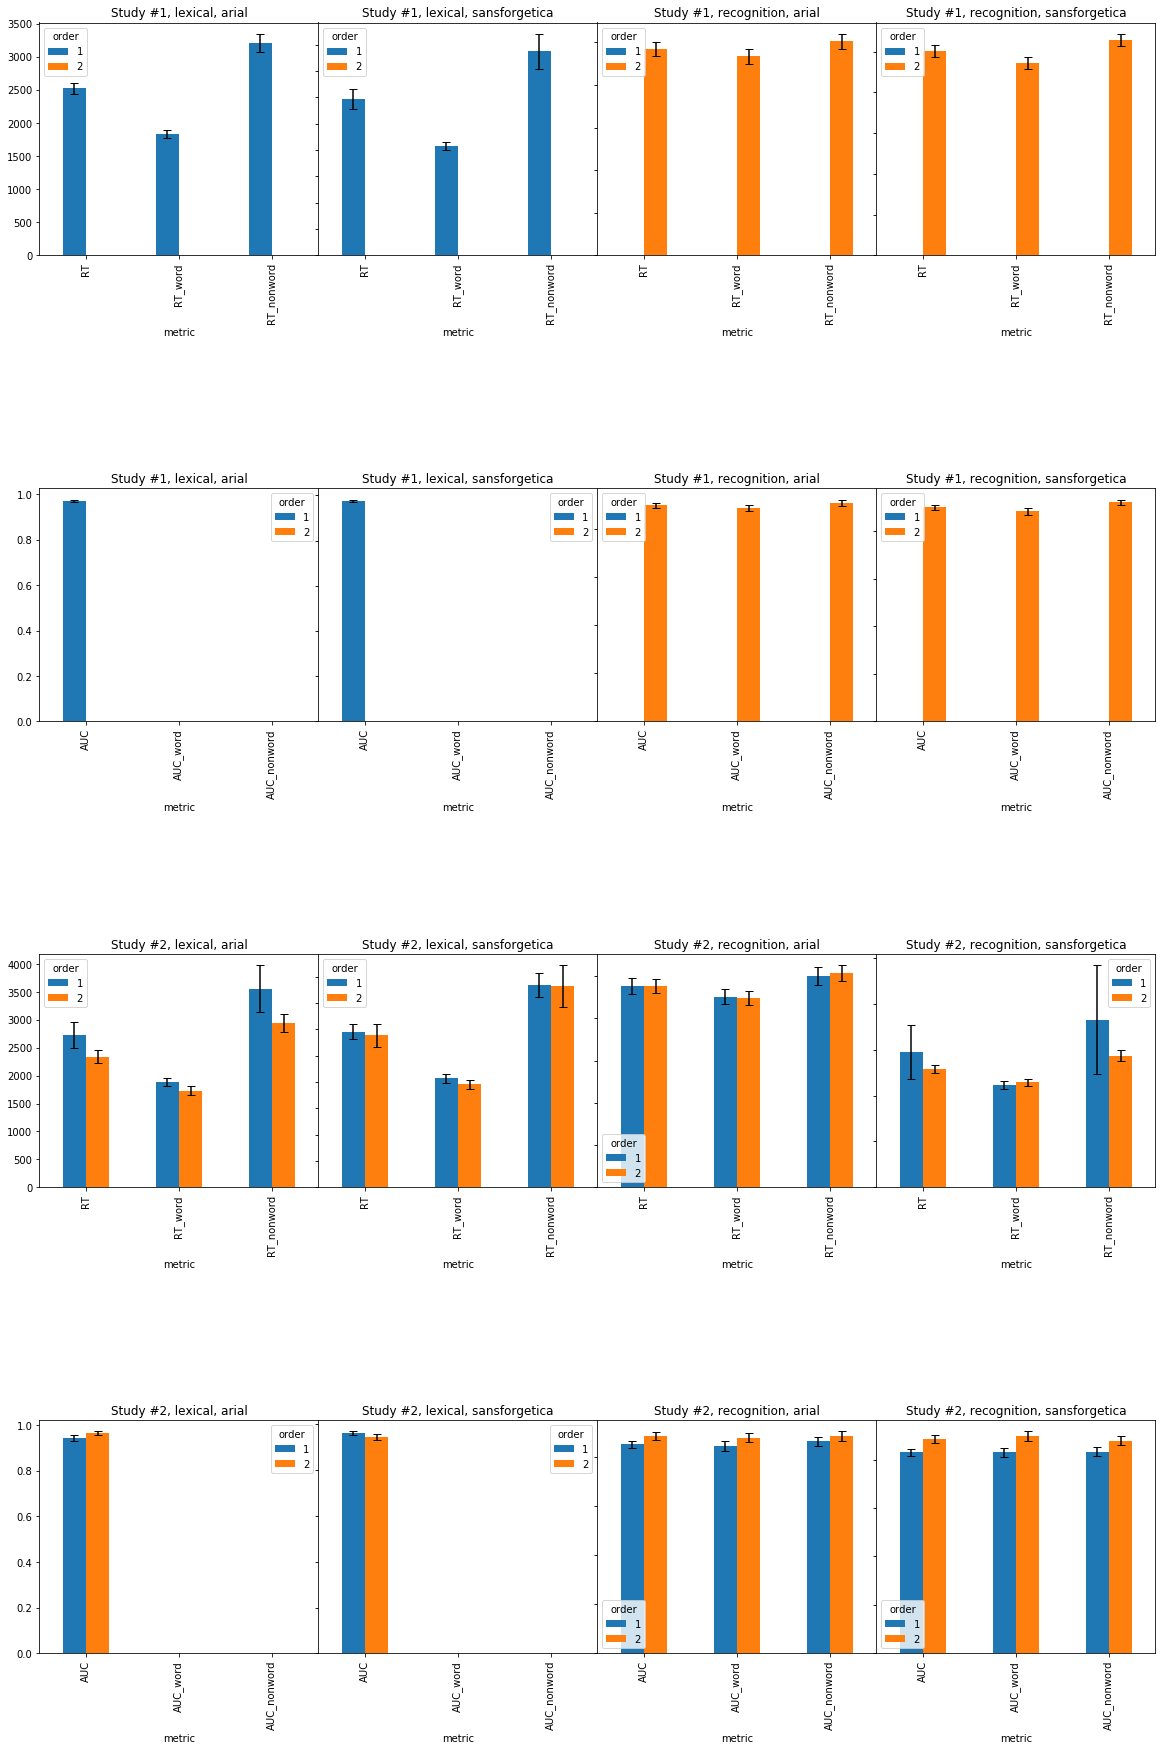

In [5]:
# comparison by order - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-order.pdf")

In [6]:
# comparison by order (simpler)

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types], names=["sid", "type"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order_simpler.csv")

order                  1                                                 \
metric                RT           RT_word          RT_nonword            
stat                mean      SEM     mean      SEM       mean      SEM   
sid type                                                                  
1   lexical      2746.47  106.882  1952.02  47.0045    3540.93  183.184   
    recognition      NaN      NaN      NaN      NaN        NaN      NaN   
2   lexical      2838.36  136.784   1978.2  57.2989    3698.51  236.867   
    recognition  2659.52  294.094  2248.03  61.5361    3071.01   581.63   

order                                                        ...            2  \
metric                AUC             AUC_word               ...      RT_word   
stat                 mean         SEM     mean        SEM    ...         mean   
sid type                                                     ...                
1   lexical      0.974923  0.00330599      NaN        NaN    ...          NaN   
    recognition       NaN         NaN      NaN        NaN    ...      2350.27   
2   lexical      0.952295  0.00818185      NaN        NaN    ...      1845.57   
    recognition  0.840164    0.011147  0.83709  0.0136741    ...      2266.89   

order                                                                         \
metric                   RT_nonword                AUC              AUC_word   
stat                 SEM       mean      SEM      mean         SEM      mean   
sid type                                                                       
1   lexical          NaN        NaN      NaN       NaN         NaN       NaN   
    recognition  55.7185    2579.68  57.9291  0.900532  0.00744519  0.886598   
2   lexical      57.3833    3389.96  217.082  0.954467  0.00859465       NaN   
    recognition  57.5491    2704.46  80.8883  0.885246   0.0114315  0.887807   

order                                               
metric                      AUC_nonword             
stat                    SEM        mean        SEM  
sid type                                            
1   lexical             NaN         NaN        NaN  
    recognition  0.00971855    0.916559  0.0084643  
2   lexical             NaN         NaN        NaN  
    recognition    0.013667    0.880891  0.0133713  

[4 rows x 24 columns]

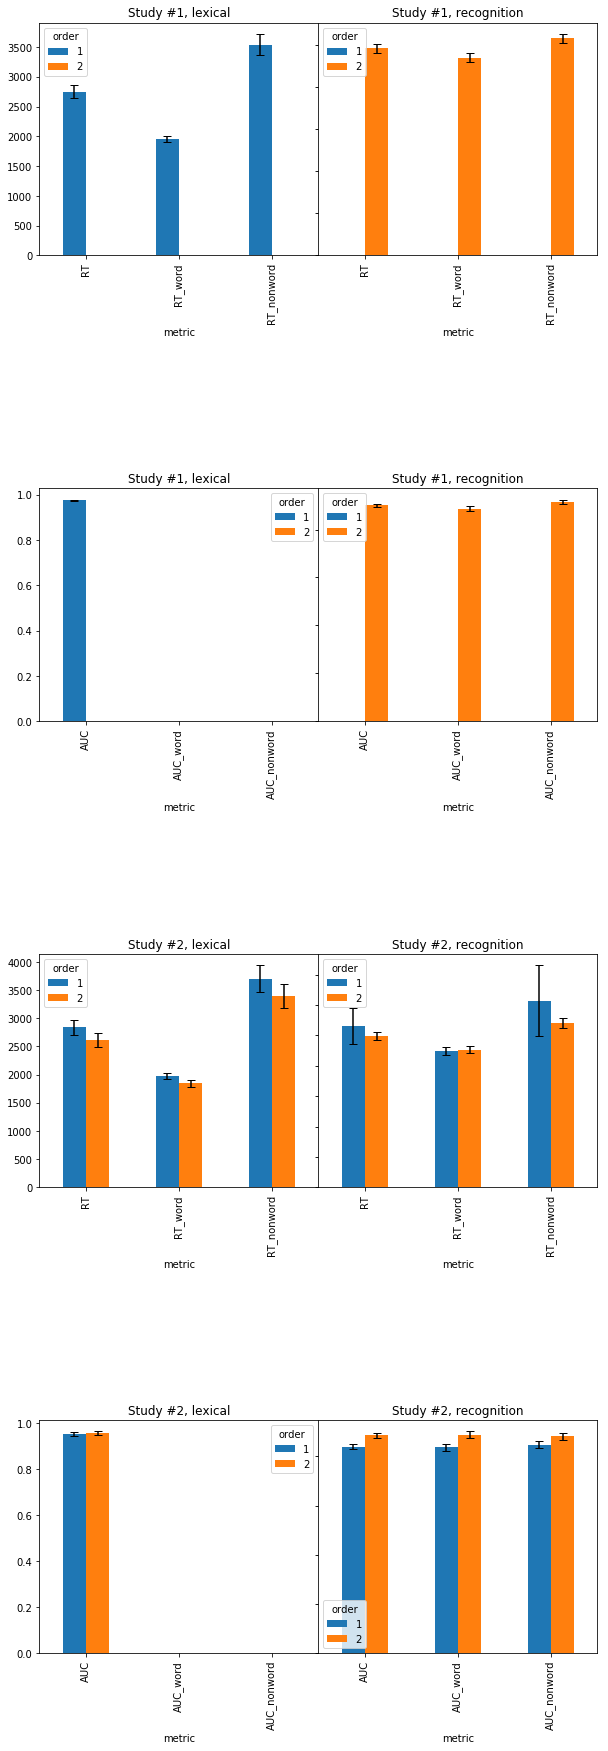

In [7]:
# comparison by order (simpler) - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 2, figsize=(10, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

for sid in [1, 2]:
    for i, t in enumerate(types):
        line = (sid - 1) * 2
        combo = (sid, t)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
fig.savefig("results/means-by-order_simpler.pdf")

In [8]:
# comparison by first font

cols = pd.MultiIndex.from_product([["arial", "sansforgetica"], metrics, ["mean", "SEM"]], names=["first", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for first in ["arial", "sansforgetica"]:
        r = st[(st["Firstfont"] == first) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (first, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (first, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-first-font.csv")

first                            arial                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial          2831.97  122.324  2004.51  96.4095    3659.42   
                sansforgetica  2946.39   134.41  2153.35  100.628    3739.43   
    recognition arial          2628.26  134.396  2523.44   138.04    2733.08   
                sansforgetica  2539.53  108.854  2408.26  115.208     2670.8   
2   lexical     arial          2722.27  229.565  1887.66  77.5692    3556.87   
                sansforgetica  2888.85  221.497  1954.48  78.3444    3823.22   
    recognition arial          2382.27  91.9004  2258.76  90.0138    2505.79   
                sansforgetica  2578.75   96.764   2287.7  79.8662    2869.79   

first                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          171.992    0.9605  0.00830325       NaN   
                sansforgetica   197.75    0.9712   0.0072921       NaN   
    recognition arial          141.756  0.900937   0.0166208  0.886875   
                sansforgetica  111.643   0.88875   0.0157719   0.87625   
2   lexical     arial          415.266  0.943871   0.0139929       NaN   
                sansforgetica  390.463  0.944677   0.0150738       NaN   
    recognition arial            106.3  0.850806   0.0156175  0.844254   
                sansforgetica  127.803  0.886215   0.0159891  0.896673   

first                                       ...     sansforgetica           \
metric                                      ...           RT_word            
stat                                 SEM    ...              mean      SEM   
sid type        font                        ...                              
1   lexical     arial                NaN    ...           1643.93  46.6738   
                sansforgetica        NaN    ...           1990.09  104.789   
    recognition arial            0.01763    ...           2134.18  84.2415   
                sansforgetica  0.0176316    ...           2320.44  90.7115   
2   lexical     arial                NaN    ...           1733.02  82.1672   
                sansforgetica        NaN    ...           2071.75  83.4911   
    recognition arial          0.0192894    ...           2245.39  83.5508   
                sansforgetica  0.0193175    ...           2236.94  84.4407   

first                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial            2735.19  191.607  0.985106  0.00370167   
                sansforgetica    4009.43  668.181  0.984043  0.00529132   
    recognition arial            2281.92  88.9244  0.896941   0.0129814   
                sansforgetica    2617.33  103.044  0.916223    0.013699   
2   lexical     arial            2942.26  164.148  0.964583  0.00786565   
                sansforgetica    3844.88  221.395     0.961  0.00821223   
    recognition arial            2533.61  94.1303  0.884245   0.0164857   
                sansforgetica    3655.07  1177.82  0.829167   0.0159228   

first                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexi

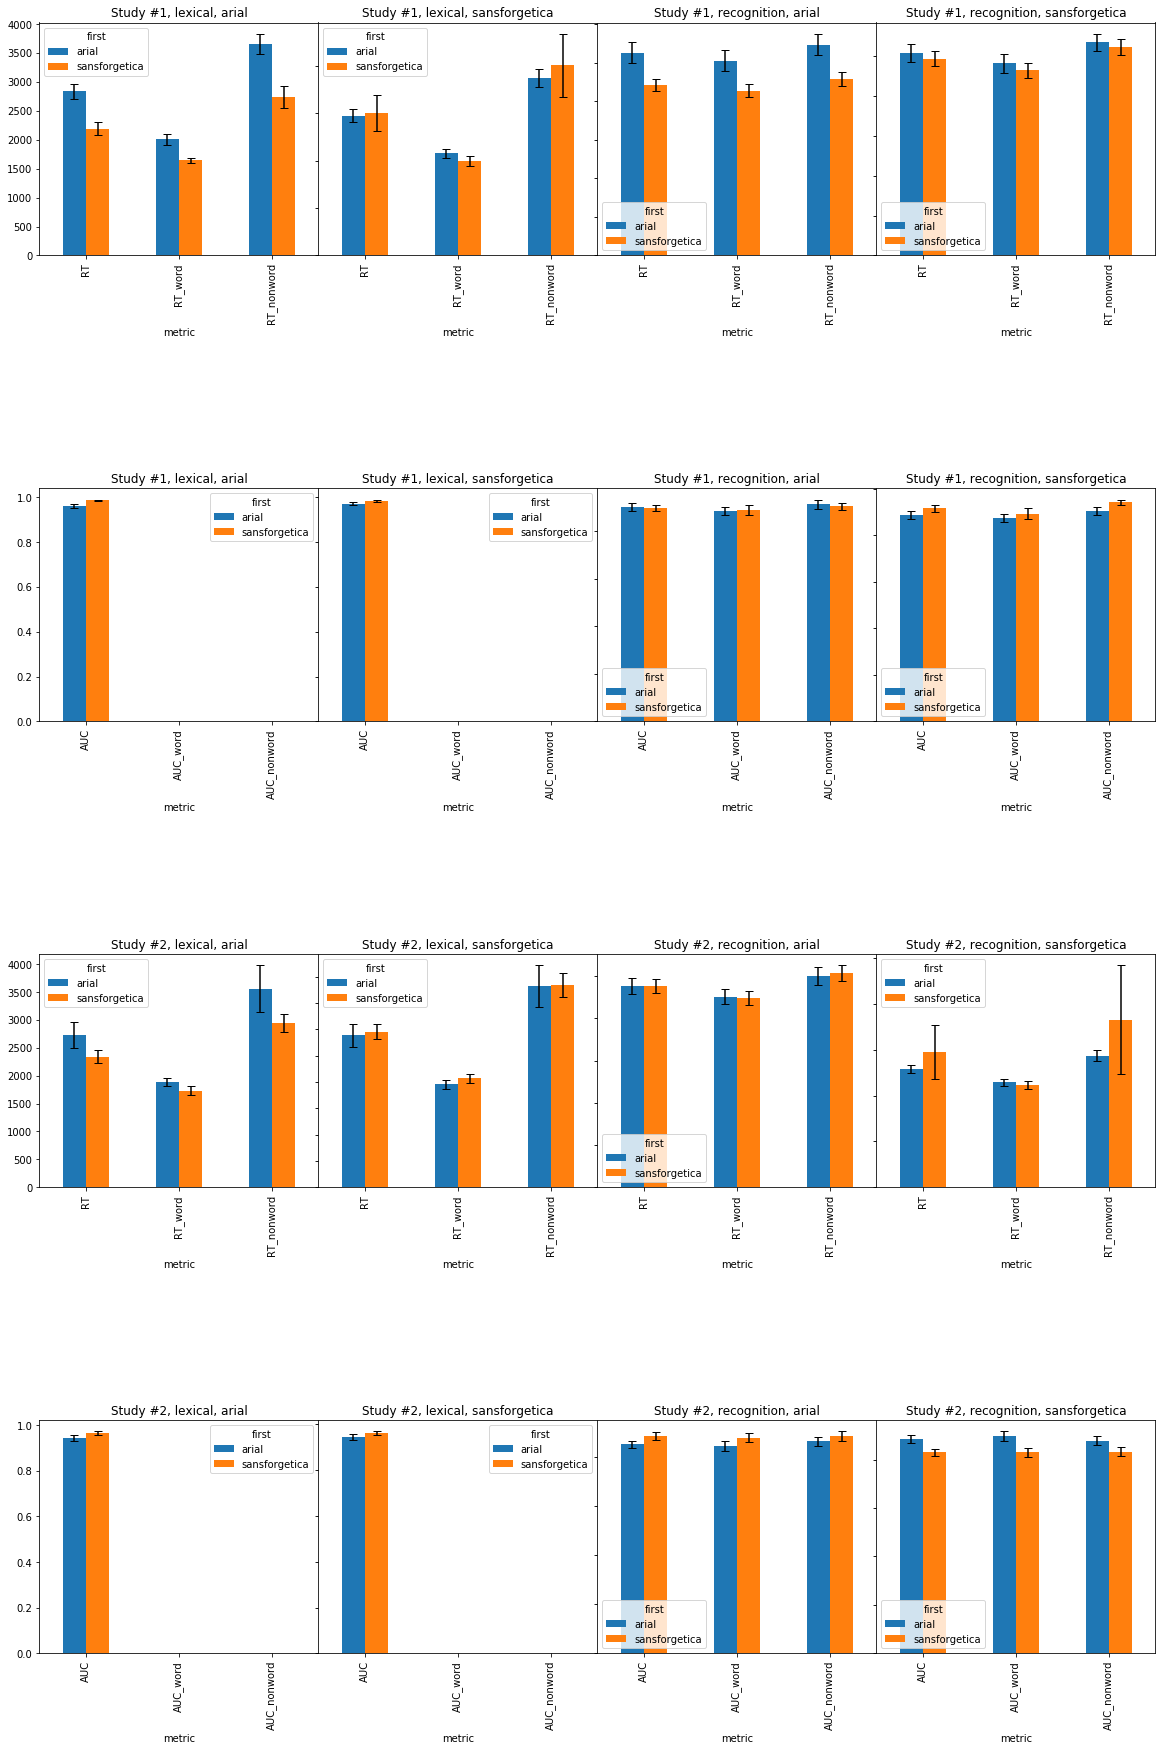

In [9]:
# comparison by first font - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-first-font.pdf")

# isDesigner



JoM                                                        \
            count       mean        std   min    25%   50%   75%    max   
isDesigner                                                                
False       176.0  53.977273  20.943449   1.0  40.75  50.0  71.5   92.0   
True        212.0  55.537736  21.664908  10.0  37.00  59.0  73.0  100.0   

              JoL                                                       
            count       mean        std  min   25%   50%    75%    max  
isDesigner                                                              
False       176.0  69.886364  30.509739  0.0  50.0  75.0  100.0  100.0  
True        212.0  62.500000  32.518679  0.0  25.0  50.0  100.0  100.0


# Font



JoM                                                      \
               count       mean        std  min   25%   50%   75%    max   
Font                                                                       
arial          194.0  56.711340  20.763139  1.0  47.0  59.0  73.0   92.0   
sansforgetica  194.0  52.948454  21.768148  7.0  35.0  50.0  71.0  100.0   

                 JoL                                                         
               count       mean        std   min   25%    50%    75%    max  
Font                                                                         
arial          194.0  90.463918  17.426121  25.0  75.0  100.0  100.0  100.0  
sansforgetica  194.0  41.237113  22.488119   0.0  25.0   50.0   50.0  100.0


# Firstfont



JoM                                                       \
               count       mean        std   min   25%   50%   75%    max   
Firstfont                                                                   
arial          200.0  55.380000  23.318541   1.0  38.0  59.0  75.0  100.0   
sansforgetica  188.0  54.244681  19.026964  14.0  41.0  50.0  70.0   90.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Firstfont                                                                  
arial          200.0  62.250000  33.530718  0.0  25.0  50.0  100.0  100.0  
sansforgetica  188.0  69.680851  29.449572  0.0  50.0  75.0  100.0  100.0


# isDesigner



JoM                                                       JoL  \
            count       mean       std  min   25%   50%   75%    max  count   
isDesigner                                                                    
False       236.0  52.237288  20.82988  6.0  37.0  50.0  70.0  100.0  236.0   
True        252.0  55.738095  19.69617  5.0  43.0  52.5  70.0  100.0  252.0   

                                                                 
                 mean        std  min   25%   50%    75%    max  
isDesigner                                                       
False       68.855932  32.278120  0.0  50.0  75.0  100.0  100.0  
True        65.079365  30.773457  0.0  25.0  75.0  100.0  100.0


# Font



JoM                                                     \
               count       mean       std  min   25%   50%   75%    max   
Font                                                                      
arial          244.0  54.045082  20.32802  5.0  40.0  50.0  70.0  100.0   
sansforgetica  244.0  54.045082  20.32802  5.0  40.0  50.0  70.0  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Font                                                                       
arial          244.0  66.905738  31.566693  0.0  50.0  75.0  100.0  100.0  
sansforgetica  244.0  66.905738  31.566693  0.0  50.0  75.0  100.0  100.0


# Firstfont



JoM                                                       \
               count       mean        std  min   25%   50%    75%    max   
Firstfont                                                                   
arial          248.0  52.975806  20.412532  7.0  37.0  50.0  70.00  100.0   
sansforgetica  240.0  55.150000  20.180628  5.0  44.5  52.5  69.25  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Firstfont                                                                  
arial          248.0  62.096774  32.519672  0.0  25.0  50.0  100.0  100.0  
sansforgetica  240.0  71.875000  29.741301  0.0  50.0  75.0  100.0  100.0

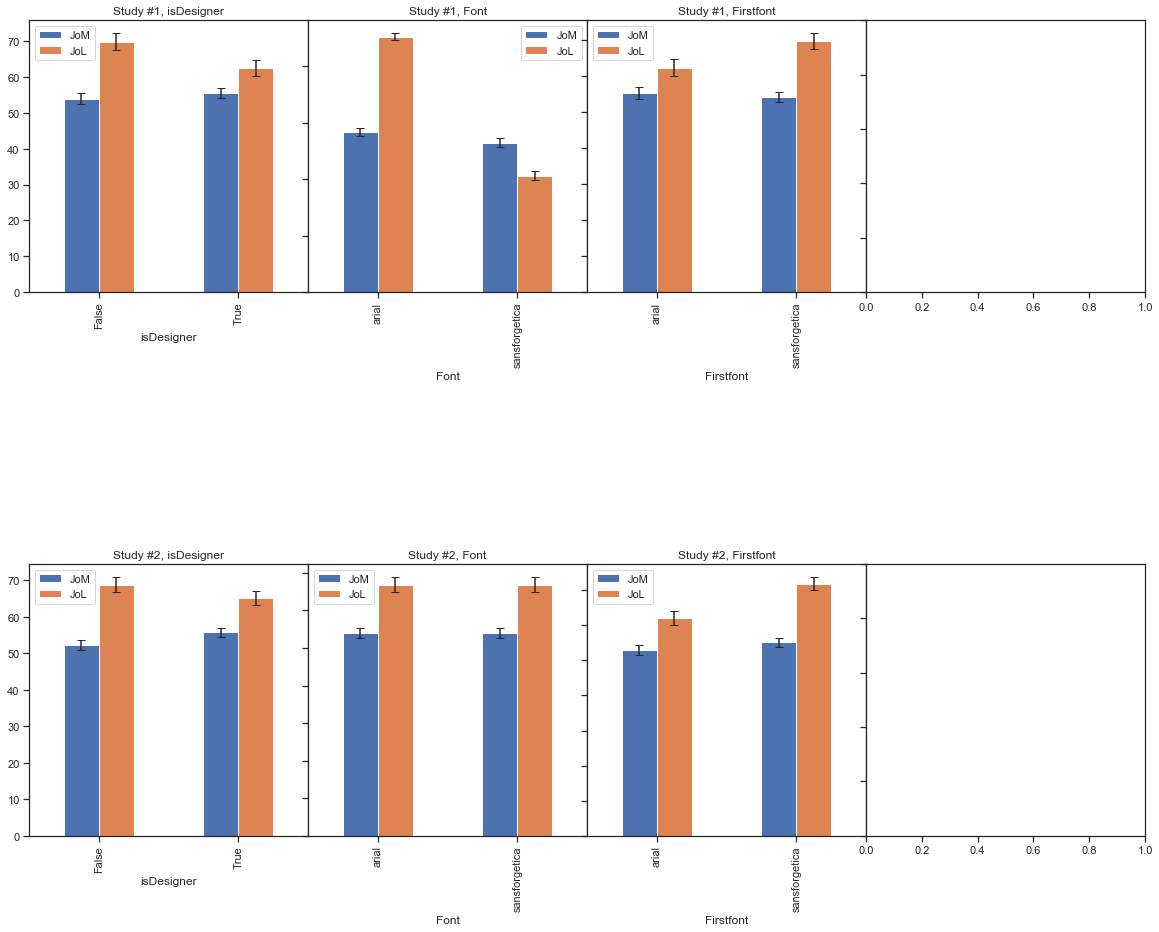

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
plt.subplots_adjust(wspace=0, hspace=1)
for sid in [1, 2]:
    for i, col in enumerate(["isDesigner", "Font", "Firstfont"]):
        print("#", col)
        print()
        display(st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].describe())
        print()
        means = st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].mean()
        errors = st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].sem()
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[sid-1][i],
                       sharey=True,
                       title="Study #%d, %s" % (sid, col))
fig.savefig("results/JoM-JoL.pdf")

